In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import yaml

sns.set_style("darkgrid")
palette = sns.color_palette()
pd.options.mode.copy_on_write = True
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), "../scripts"))
sys.path.append(scripts_dir)
workflows_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(workflows_dir)

# pretty print
pretty_print = {"string": "STRING",
      "gseapy": "GSEApy",
      "clusterProfiler": "ClusterProfiler",
      "neg_signed_logpval": "signed logPValue",
      "logFC": "logFC"}

# Define params

- `input_file`: Path (relative to project root) to a csv file containing a table with gene names and ranking metric(s). Input files should be put in the `resources` folder.
  
- `project_name`: A string to tag output files. Results will be saved in `results/{project_name}/some_filename.{project_name}.csv`

- `metrics`: A list of strings specifying columns in the input table that are used to rank the genes.

In [23]:
#### User-defined variables ####

input_file = "resources/Carmen/edger.paired.qlf.lfc0.csv"
project_name = "Carmen.paired.QLF"

input_file = "resources/Chiara/edger.qlf.lfc0.KO_WT.p1.csv"
project_name = "Chiara.QLF.KO_WT"

input_file = "resources/Chiara/edger.qlf.lfc0.SA_WT.p1.csv"
project_name = "Chiara.QLF.SA_WT"

input_file = "resources/Chiara/edger.qlf.lfc0.SD_WT.p1.csv"
project_name = "Chiara.QLF.SD_WT"

input_file = "resources/Chiara/edger.qlf.lfc0.KO_SD.p1.csv"
project_name = "Chiara.QLF.KO_SD"

input_file = "resources/Chiara/edger.qlf.lfc0.KO_SA.p1.csv"
project_name = "Chiara.QLF.KO_SA"

input_file = "resources/Chiara/edger.qlf.lfc0.SD_SA.p1.csv"
project_name = "Chiara.QLF.SD_SA"

input_file = "resources/Chiara/permuted.edger.qlf.lfc0.KO_SA.p1.csv"
project_name = "permuted.Chiara.QLF.SD_SA"

# input_file = "resources/TCGA/BRCA.edgerqlf.lfc0.csv"
# project_name = "BRCA.QLF"

# input_file = "resources/TCGA/THCA.edgerqlf.lfc0.csv"
# project_name = "THCA.QLF"

# input_file = "resources/TCGA/KIRC.edgerqlf.lfc0.csv"
# project_name = "KIRC.QLF"

# input_file = "resources/TCGA/LIHC.edgerqlf.lfc0.csv"
# project_name = "LIHC.QLF"


metrics = ['logFC', 'neg_signed_logpval']
libraries = ["KEGG","GO"]
tools = ["clusterProfiler","gseapy"]#,"string"]

# ClusterProfiler

keytype = "ENSEMBL"
organismKEGG = "hsa"

In [ ]:
#### User-defined variables ####

input_file = "resources/Liana/deg.edger.lrt.batch.unm_0.6.clean.clExc7_DL.thresh.0.2.2024-01-22-17-42.P90.p19rc.csv"
project_name = "met.Exc7_DL.P90.p19rc"


# input_file = "resources/Liana/deg.edger.lrt.batch.unm_0.6.clean.clInh_Sncg.thresh.0.2.2024-01-19-11-47.P14.p19rc.csv"
# project_name = "met.Inh_Sncg.P14.p19rc"


metrics = ['logFC', 'neg_signed_logpval']
libraries = ["KEGG","GO"]
tools = ["clusterProfiler","gseapy","string"]

# ClusterProfiler

keytype = "SYMBOL"
organismKEGG = "mmu"

## Create config.yaml file

In [24]:
# Create configuration dictionary
config_data = {
    'input_file': input_file,
    'project_name': project_name,
    'metrics': metrics,
    'keytype': keytype,
    'organismKEGG': organismKEGG,
    'libraries': libraries,
    'tools': tools,
    'qval': 0.05,
    'save_summary_dict': True
}

# Write to config.yaml
config_filename = "../../config/config.yaml"
with open(config_filename, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Configuration file '{config_filename}' created successfully!")

savepath = f"../../results/{project_name}/"
figpath = f"../../results/{project_name}/figures/"
!mkdir -p $figpath

Configuration file '../../config/config.yaml' created successfully!


# Inspect/modify input

This space can be used to calculate further ranking metrics that are missing in the input table. As an example, we read the output table from edgeR, calculate $-\mathrm{sign}(\log_2\mathrm{FC})\times\log_{10}(p\mathrm{-value})$, and add this as a new column to the table.

**Careful:** Updating input files after jobs have been run will re-run the jobs the next time Snakemake is run. To prevent this, you can use `--touch` to update the timestamps of previously generated output files:

`snakemake --touch --cores 1`

In [22]:
df = pd.read_csv(f"../../{input_file}", index_col=0)
df["neg_signed_logpval"] = -np.sign(df["logFC"]) * np.log10(df["PValue"])
display(df.sort_index().head())
sig = df[df["FDR"]<0.01]
print(len(sig))

#df.index = df.sample(frac=1)
#df.to_csv(f"../../{input_file}")

# permute data
# ix = list(range(len(df)))
# np.random.shuffle(ix)
# df.index = df.iloc[ix].index
# df.sort_index()
# df.to_csv(f"../../{input_file}")

,gene_name,logFC,logCPM,PValue,FDR,neg_signed_logpval
ENSG00000000003,TSPAN6,-0.269814,5.038146,5.879247e-03,0.200346,-2.230678
ENSG00000000419,DPM1,0.014090,6.621561,8.764600e-01,0.991049,0.057268
ENSG00000000457,SCYL3,0.031547,3.259211,7.835708e-01,0.984765,0.105922
ENSG00000000460,FIRRM,-0.092301,4.927806,4.664184e-01,0.931774,-0.331224
ENSG00000000971,CFH,-1.000243,5.604210,5.109037e-08,0.000222,-7.291661


67


## Correlations

Inspect correlations between the two different ranking metrics (e.g. logFC and signed pvalue)

In [ ]:
rank1 = "logFC"
rank2 = "neg_signed_logpval"

fig, ax = plt.subplots(1, 2, figsize=(10,5))

### Pearson correlation

correlation = df[rank1].corr(df[rank2], method='pearson')
sns.regplot(x=df[rank1], y=df["neg_signed_logpval"], ax=ax[0], scatter_kws={'alpha':0.1}, line_kws={"color":palette[3]})
ax[0].set_title(f"Pearson: {correlation:.2f}")

ax[0].set(xlabel=rank1)
ax[0].set(ylabel="-sign(logFC)*log10(p-value)")

### Spearman rank correlation

df['rank1'] = df[rank1].rank(method='average')
df['rank2'] = df[rank2].rank(method='average')
rank_correlation = df['rank1'].corr(df['rank2'], method='spearman')

sns.regplot(x=df['rank1'] ,y=df['rank2'], ax=ax[1], scatter_kws={'alpha':0.01}, line_kws={"color":palette[3]})
ax[1].set_title(f"Spearman: {rank_correlation:.2f}")
fig.tight_layout()

ax[1].set(xlabel="logFC [Rank]")
ax[1].set(ylabel="-sign(logFC)*log10(p-value) [Rank]")

# Run Snakemake

Run the following command in project root directory:

`snakemake --use-conda --cores 1` (adjust number of cores as needed)

In [ ]:
# import subprocess

# cores = 1
# command = f"snakemake -s ../Snakefile --configfile ../../config/config.yaml --use-conda --cores {cores}"
# subprocess.run(command, shell=True, check=True)

# Inspect results

## Load results

In [25]:
import pickle
import matplotlib
from scripts.plots import npg_palette

npg = npg_palette()
output_files = glob.glob(f"{savepath}/syn.*[tc]sv")
print(f"Found {len(output_files)} output files:\n",*[o+"\n" for o in output_files])

summary_dict_file = f"{savepath}/combined/syn.summary_dict.{project_name}.txt"
with open(summary_dict_file, "rb") as f:
    summary_dict = pickle.load(f)

print("summary_dict loaded")
summary_dict.keys()

Found 8 output files:
 ../../results/permuted.Chiara.QLF.SD_SA/syn.clusterProfiler.logFC.KEGG.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.gseapy.logFC.KEGG.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.clusterProfiler.neg_signed_logpval.GO.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.gseapy.neg_signed_logpval.KEGG.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.clusterProfiler.neg_signed_logpval.KEGG.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.clusterProfiler.logFC.GO.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.gseapy.logFC.GO.permuted.Chiara.QLF.SD_SA.csv
 ../../results/permuted.Chiara.QLF.SD_SA/syn.gseapy.neg_signed_logpval.GO.permuted.Chiara.QLF.SD_SA.csv

summary_dict loaded


dict_keys(['KEGG', 'GO'])

In [ ]:
# In case another qval threshold should be used
# from scripts.combine_libs import create_summary_dict
#summary_dict = create_summary_dict(f"{savepath}/combined",libraries,tools,metrics,project_name, qval=0.01, save=False)

## Intersection depth

We count the number of unique analysis configuations (methods, rankings) each significant term appears in. We designate this as the *intersection depth* of a term. A depth of $N$ means that the corresponding enrichment term is significant in exactly $N$ configurations.

In [ ]:
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(1, 2, figsize=(10,3))

# for ax, lib in zip(axes,summary_dict):
#     depth_df = summary_dict[lib]["depth_df"]
#     h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
#                  discrete=True, ax=ax, alpha=1)
#     h.bar_label(h.containers[0])
#     ax.set(title=lib, xlabel="Depth", ylabel="Terms")
#     ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
#     ax.grid(axis='x')

# fig.tight_layout()
# fig.savefig(f"{figpath}/intersection_depth.{project_name}.pdf")

In [ ]:
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(1, 2, figsize=(10,5))

# for ax, lib in zip(axes,summary_dict):
#     summary_df = summary_dict[lib]["summary_df"]
#     qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
#     qv = qv.xs("qvalue", level=2, axis=1)
#     qv = qv.replace(np.nan,1)
#     qv = qv < qval

#     qqv=qv.sum().reset_index()
#     qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
#     qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
#     qqv = qqv.drop(["Tool","Metric"], axis=1)
#     qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

#     b = sns.barplot(x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1)
#     for i in b.containers:
#         b.bar_label(i,)
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set(title=lib, ylabel="Terms", xlabel=None)

# fig.tight_layout()
# fig.savefig(f"{figpath}/number_sig_terms.{project_name}.pdf")

TypeError: 'NoneType' object is not subscriptable

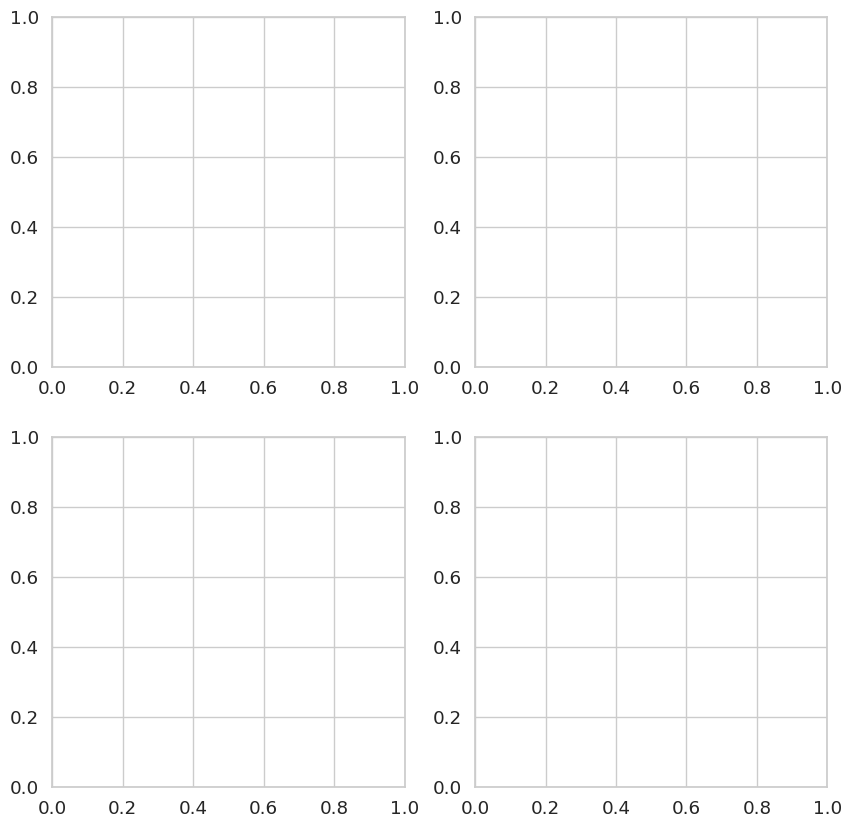

In [26]:
palette = npg

sns.set(font_scale=1.2)
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()
qval = 0.05

### Intersection depth

for ax, lib in zip(axes[:2],libraries):
    depth_df = summary_dict[lib]["depth_df"]
    h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[3])
    h.bar_label(h.containers[0])
    ax.set(title=lib, xlabel="Intersection Depth", ylabel="Terms")
    ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
    ax.grid(axis='x')        
    
### Number of terms

for ax, lib in zip(axes[2:], libraries):
    summary_df = summary_dict[lib]["summary_df"]
    qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
    qv = qv.xs("qvalue", level=2, axis=1)
    qv = qv.replace(np.nan,1)
    qv = qv < qval

    qqv=qv.sum().reset_index()
    qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
    qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
    qqv = qqv.drop(["Tool","Metric"], axis=1)
    qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

    if ax == axes[2]:
        hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

    qqv["hue"] = qqv.index
    b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
    for i in b.containers:
        b.bar_label(i,)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
    ax.set(title=lib, ylabel="Terms", xlabel=None)
    
    # apply offset transform to all x ticklabels.
    offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

fig.tight_layout()
fig.savefig(f"{figpath}/bars.{project_name}.pdf")

## Venn diagrams

In [ ]:
from scripts.explore_results import get_sig_dict
from scripts.plots import plot_venn

fig, ax = plt.subplots(2, 2, figsize=(8,8))

for i, lib in enumerate(libraries):
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, metric in enumerate(metrics):
        plot_venn(sig_dict, tools, metric, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[metric]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig(f"{figpath}/venn.methodcomp.{project_name}.pdf")


fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, lib in enumerate(libraries):
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, tool in enumerate(tools):
        plot_venn(sig_dict, tool, metrics, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[tool]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig(f"{figpath}/venn.metriccomp.{project_name}.pdf")

## UpSet plots

Useful for visualizing set intersection with more than 3 sets. 

https://upsetplot.readthedocs.io/en/stable/index.html

In [ ]:
from matplotlib import pyplot
from upsetplot import from_memberships
from upsetplot import UpSet

for lib in libraries:

    depth_df = summary_dict[lib]["depth_df"]
    memberships = depth_df["Factors"]
    memberships_list = [categories.split(" | ") for categories in memberships.values]
    upset_ready = from_memberships(memberships_list)
    upset_ready.index.names = [" ".join([pretty_print[i] for i in u.split(".")]) for u in upset_ready.index.names] # pretty print

    pd.options.mode.copy_on_write = False
    UpSet(upset_ready, subset_size="count", sort_by="cardinality", show_counts="{:,}").plot()
    pd.options.mode.copy_on_write = True
    pyplot.savefig(f"{figpath}/upset.{lib}.{project_name}.pdf")

# Meta-analysis

Compare multiple datasets

In [ ]:
import pickle
from scripts.plots import npg_palette

npg = npg_palette()

#project_names = ["BRCA.LRT", "Carmen.unpaired.LRT", "Chiara.KO_WT", "Chiara.SA_WT", "met.Exc7_DL.P90.p19rc"]
project_names = ["THCA.QLF","BRCA.QLF", "KIRC.QLF", "LIHC.QLF",
                 "Carmen.paired.QLF", 
                 "Chiara.QLF.KO_WT", "Chiara.QLF.SA_WT", "Chiara.QLF.SD_WT",
                 "met.Exc7_DL.P90.p19rc", "met.Inh_Sncg.P14.p19rc"]

pretty_datanames = {"BRCA.QLF":"TCGA.BRCA.N-T",
                    "THCA.QLF":"TCGA.THCA.N-T",
                    "KIRC.QLF":"TCGA.KIRC.N-T",
                    "LIHC.QLF":"TCGA.LIHC.N-T",
                    "met.Exc7_DL.P90.p19rc": "sn.Exc7.P90.WT-SA",
                    "met.Inh_Sncg.P14.p19rc": "sn.Inh.Sncg.P14.WT-SA",
                    "Chiara.QLF.KO_WT":"Ser1016.WT-KO",
                    "Chiara.QLF.SA_WT":"Ser1016.WT-SA",
                    "Chiara.QLF.SD_WT":"Ser1016.WT-SD",
                    "Carmen.paired.QLF":"CHK2.WT-KO"}

meta_dict = dict()
for project in project_names:
    try:
        with open(f"../../results/{project}/{project}.summary_dict.txt", "rb") as f:
            meta_dict[project] = pickle.load(f)
    except FileNotFoundError:
        print(f"Project not found: {project}")

npg

In [ ]:
meta_depth_dict = dict()

for lib in libraries:
    meta_depth_df = []
    for project in meta_dict:
        depth_df_p = meta_dict[project][lib]["depth_df"]
        depth_df_p["Project"] = project
        depth_df_p.replace({"Project":pretty_datanames}, inplace=True)
        meta_depth_df.append(depth_df_p)

    meta_depth_df = pd.concat(meta_depth_df)
    meta_depth_dict[lib] = meta_depth_df

In [ ]:
meta_summary_dict = dict()

for lib in libraries:
    meta_summary_df = []
    for project in meta_dict:
        df = meta_dict[project][lib]["summary_df"]
        df.index = df.index + "." + project # needed for venn
        meta_summary_df.append(df)

    meta_summary_df = pd.concat(meta_summary_df)
    meta_summary_dict[lib] = meta_summary_df

In [ ]:
import matplotlib

palette = npg

sns.set(font_scale=1.2)
#sns.set_style("whitegrid")
sns.set_style("ticks")

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

### Intersection depth

for ax, lib in zip(axes[:2],meta_depth_dict):
    sns.despine()
    depth_df = meta_depth_dict[lib]
    h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[3], label="Non-TCGA")
    h.bar_label(h.containers[0])
    ax.set(title=lib, xlabel="Intersection Depth", ylabel="Terms")
    ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
    ax.grid(axis='x')

    ### plot TCGA only on top
    TCGA = depth_df[depth_df["Project"].str.startswith("TCGA")]
    sns.histplot(TCGA['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[5], label="TCGA")
    
    ### label bars    
    nonTCGA = depth_df[~depth_df["Project"].str.startswith("TCGA")]
    nonTCGA_counts = nonTCGA['Depth'].value_counts().sort_index()
    TCGA_counts = TCGA['Depth'].value_counts().sort_index()
    for i in range(depth_df["Depth"].max()):
        ax.text(s=TCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]/2,  va='center',ha='center')
        ax.text(s=nonTCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]+nonTCGA_counts.iloc[i]/2,  va='center',ha='center',color="white")

    ax.legend(loc="best")
    ax.grid(False)

    if ax == axes[0]:
        pass#ax.set_ylim(0,349)

### Number of terms

for ax, lib in zip(axes[2:], meta_summary_dict):
    sns.despine()
    summary_df = meta_summary_dict[lib]
    qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
    qv = qv.xs("qvalue", level=2, axis=1)
    qv = qv.replace(np.nan,1)
    qv = qv < qval

    qqv=qv.sum().reset_index()
    qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
    qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
    qqv = qqv.drop(["Tool","Metric"], axis=1)
    qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

    if ax == axes[2]:
        hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

    qqv["hue"] = qqv.index
    b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
    for i in b.containers:
        b.bar_label(i,)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
    ax.set(title=lib, ylabel="Terms", xlabel=None)

    # apply offset transform to all x ticklabels.
    offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
        
for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

fig.tight_layout()
fig.savefig("../../results/meta/bars.meta.pdf")

In [ ]:
from scripts.plots import plot_venn

fig, ax = plt.subplots(2, 2, figsize=(8,8))

for i, lib in enumerate(libraries):
    summary_df = meta_summary_dict[lib]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, metric in enumerate(metrics):
        plot_venn(sig_dict, tools, metric, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[metric]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig("../../results/meta/venn.methodcomp.meta.pdf")


fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, lib in enumerate(libraries):
    summary_df = meta_summary_dict[lib]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, tool in enumerate(tools):
        plot_venn(sig_dict, tool, metrics, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[tool]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig("../../results/meta/venn.metriccomp.meta.pdf")

In [ ]:
from matplotlib import pyplot
from upsetplot import from_memberships, UpSet

for lib in libraries:

    depth_df = meta_depth_dict[lib]
    memberships = depth_df["Factors"]
    memberships_list = [categories.split(" | ") for categories in memberships.values]
    upset_ready = from_memberships(memberships_list)
    upset_ready.index.names = [" ".join([pretty_print[i] for i in u.split(".")]) for u in upset_ready.index.names] # pretty print

    pd.options.mode.copy_on_write = False
    UpSet(upset_ready, subset_size="count", sort_by="cardinality", show_counts="{:,}", orientation="vertical").plot()
    pd.options.mode.copy_on_write = True
    pyplot.savefig(f"../../results/meta/upset.{lib}.meta.pdf", bbox_inches='tight')

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

### Number of terms per dataset

for ax, lib in zip(axes[:2],libraries):
    sns.despine()
    depth_df = meta_depth_dict[lib]
    depth_df.replace({"Project":pretty_datanames}, inplace=True)

    counts = depth_df.groupby(["Project"]).count()["Factors"].sort_values(ascending=False)

    counts = pd.DataFrame(counts)

    counts["hue"] = counts.index
    #counts.replace({"hue":pretty_datanames}, inplace=True)

    if ax == axes[0]:
        hue_order = {counts.iloc[i]["hue"]: npg[i] for i in range(len(counts))}
        
    b = sns.barplot(data=counts, y="Factors", x="hue", ax=ax, hue="hue", hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(title=lib,xlabel=None,ylabel="Combined Terms")

    for i in b.containers:
        b.bar_label(i,)

    if ax == axes[1]:
        ax.set_ylim(0,2999)
    
    if ax == axes[0]:
        ax.set_ylim(0,199)

    # mark depths with horzontal lines
    g = depth_df.groupby(["Project"])["Depth"].value_counts()
    for j, p in enumerate(counts.index):
        sum = 0
        prev_sum = 0
        maxdepth = g.index.get_level_values("Depth").max()
        for i in range(1,1+maxdepth):
            try:
                sum += g.loc[(p,i)]
            except KeyError:
                pass
            if i < maxdepth:
                ax.scatter(j, sum, marker="_", color="black", s=550, alpha=0.5)
            if j == 0:
                ax.text(s=f"d{i}",x=j,y=prev_sum + 0.5*(sum-prev_sum), ha="center", va="center",fontsize=10)
            prev_sum = sum

for ax, lib in zip(axes[2:], libraries):
    depth_df = meta_depth_dict[lib]
    #depth_df.replace({"Project":pretty_datanames}, inplace=True)
    #sns.barplot(data=depth_df, x="Project", y="Depth", hue="Project", errorbar="sd", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    sns.boxplot(data=depth_df, x="Project", y="Depth", hue="Project", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(ylabel="Enrichment Depth",title=lib)

    if ax == axes[3]:
        ax.set_ylim(axes[2].get_ylim())

for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)
    axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=30, ha='right')
    axes[i].set(xlabel=None)

    # annotate KI
    axes[i].axvline(len(pretty_datanames)-4.5,0,axes[i].get_ylim()[1],ls="--",color="black",alpha=0.7)
    #axes[i].annotate("KI", xy=(0,0), xytext=(len(pretty_datanames)-3, 0.8*axes[i].get_ylim()[1] ), xycoords="data",zorder=99)

    if i == 0:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.8), xycoords="axes fraction",zorder=99)
    elif i == 1:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.735), xycoords="axes fraction",zorder=99)
    elif i == 2:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)
    else:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)

fig.tight_layout()
fig.savefig("../../results/meta/bars.data.meta.pdf")

In [ ]:
# LaTeX

basestring = '''\\begin{figure}[!htb]
\centering
\includegraphics[width=1\\textwidth]{Figures/SynEnrich/Supplement/bars.BLANK.pdf}
%\decoRule
\caption[Depth and number of enriched terms (PRETTYNAME).]{\\textbf{Intersection depth and number of enriched terms per configuration (PRETTYNAME).} Top row: Intersection depth of all significant KEGG and GO terms. Bottom row: Number of significant terms for each configuration.}
\label{fig:res:enrich:bars.BLANK}
\end{figure}

\\begin{figure}[!htb]
\centering
\includegraphics[width=0.8\\textwidth]{Figures/SynEnrich/Supplement/venn.methodcomp.BLANK.pdf}
%\decoRule
\caption[Venn diagrams of enrichment methods (PRETTYNAME).]{\\textbf{Venn diagrams comparing results from different enrichment tools (PRETTYNAME).}}
\label{fig:res:enrich:venn3:BLANK}
\end{figure}

\\begin{figure}[!htb]
\centering
\includegraphics[width=1\\textwidth]{Figures/SynEnrich/Supplement/venn.metriccomp.BLANK.pdf}
%\decoRule
\caption[Venn diagrams of ranking metrics (PRETTYNAME).]{\\textbf{Venn diagrams comparing results from different ranking metrics (PRETTYNAME).} }
\label{fig:res:enrich:venn2:BLANK}
\end{figure}

'''

finalstring = ''''''

for name, prettyname in pretty_datanames.items():
    finalstring += basestring.replace("BLANK",name).replace("PRETTYNAME",prettyname)

print(finalstring)

# Format STRING table

User can (optionally) manually add STRING functional scoring output tables to the results folder, and they will be combined with the output from SynEnrich. For this, STRING tables have to be formatted first.

In [ ]:
from scripts.utils import format_string_table

string_file1 = f"{savepath}/syn.string.logFC.{project_name}.tsv"
string_file2 = f"{savepath}/syn.string.neg_signed_logpval.{project_name}.tsv"

for string_file in [string_file1, string_file2]:

    string = pd.read_csv(string_file, index_col=0, sep="\t")

    for library in ["GO", "KEGG"]:
        string_formatted = format_string_table(string, library)
        #display(string_formatted.head())
        string_formatted.to_csv(string_file.replace(f"{project_name}.tsv", f"{library}.{project_name}.csv"))

In [ ]:
df = pd.read_csv("../../"+input_file, index_col=0)
p = "../../" + "/".join(input_file.split("/")[:-1])
name = input_file.split("/")[-1]
df["logFC"].to_csv(os.path.join(p,"gseapy.logFC."+name), header=False)
df["neg_signed_logpval"].to_csv(os.path.join(p,"gseapy.neg_signed_logpval."+name), header=False)

# from scripts import combine_libs
# import importlib
# importlib.reload(combine_libs)

# Test stuff

## ClusterProfiler

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
source("../../.Rprofile")
.libPaths()

In [ ]:
%%R -i input_file
library(clusterProfiler)
library(org.Hs.eg.db)

In [ ]:
%%R

filepath <- paste0("../../",input_file)

metrics = c("neg_signed_logpval","logFC")

df <- read.csv(filepath, row.names = 1)

for (metric in metrics) {
    # Check if the metric is in the columns
    if (!(metric %in% colnames(df))) {
            if (metric == "neg_signed_logpval") {
                message(paste("Adding", metric, "to df"))
                df$neg_signed_logpval <- -sign(df$logFC) * log10(df$PValue)
            } else {
                stop(paste("Metric", metric, "not in columns!"))
            }
        }
}

head(df)

In [ ]:
%%R

run_clusterProfiler <- function(df, savepath, paramset,
                                metric, cluster, overwrite=FALSE, 
                                organism.KEGG="hsa",
                                organism.GO = org.Hs.eg.db, seed=123) 
{
  set.seed(seed)

  outfile_go <- paste0(savepath,"/cluster.gseGO.",metric,".",paramset,".csv")
  outfile_kegg <- paste0(savepath,"/cluster.gseKEGG.",metric,".",paramset,".csv")
  print(outfile_go)
  print(outfile_kegg)

  if (file.exists(outfile_go) && file.exists(outfile_kegg) && !overwrite) {
    print("Existing files not overwritte, skipping")
    return
  }

  start_time <- Sys.time()

  geneList <- df[[metric]]
  names(geneList) <- df$ENTREZID
  geneList = sort(geneList, decreasing = TRUE)

  if (!file.exists(outfile_go) || overwrite) {

    ego3 <- gseGO(geneList     = geneList,
                  OrgDb        = organism.GO,
                  ont          = "ALL", ## CC MF BP
                  minGSSize    = 10,
                  maxGSSize    = 500,
                  pvalueCutoff = 1,
                  eps = 0,
                  seed = TRUE,
                  verbose = FALSE)
    write.csv(ego3,outfile_go)
  }

  if (!file.exists(outfile_kegg) || overwrite) {

    kegg <- gseKEGG(geneList     = geneList,
                  organism        =  organism.KEGG,
                  minGSSize    = 10,
                  maxGSSize    = 500,
                  pvalueCutoff = 1,
                  eps = 0,
                  seed = TRUE,
                  verbose = FALSE)
    write.csv(kegg,outfile_kegg)
  }

  end_time <- Sys.time()
  print(end_time - start_time)
}

convert_df <- function(df, OrgDb=org.Hs.eg.db) {

  if ("ENTREZID" %in% names(df)) return(df)
  
  df$ENSEMBL <- row.names(df)
  # Convert to ENTREZ ID
  # We will lose some genes here because not all IDs will be converted

  ids<-bitr(row.names(df), fromType = "ENSEMBL", toType = "ENTREZID", OrgDb=OrgDb)
  df <- merge(df, ids, by = "ENSEMBL", all.x = TRUE)
  print(paste("Before",nrow(df)))
  df <- na.omit(df)
  print(paste("After",nrow(df)))
  return(df)
}

In [ ]:
%%R
df <- convert_df(df, OrgDb=org.Hs.eg.db)
head(df)

In [ ]:
%%R -i project_name
savepath <- paste0("../../results/",project_name)
paramset <- "test"
metric <- "neg_signed_logpval"
df <- convert_df(df, OrgDb=org.Hs.eg.db)
run_clusterProfiler(df, savepath, paramset,
                                metric, overwrite=FALSE, 
                                organism.KEGG="hsa",
                                organism.GO = org.Hs.eg.db) 